In [1]:
from functools import reduce

In [2]:
import gmm

In [3]:
%cd ../..

/home/work/AnacondaProjects/combinators


In [4]:
from combinators import lens, sampler, tracing
from combinators.model import collections

In [5]:
D = 2
K = 3
N = 5
NUM_SAMPLES = 1

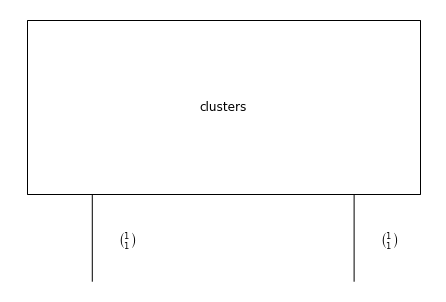

In [6]:
clusters = sampler.ImportanceSampler(gmm.GaussianClusters(K, D), None, (NUM_SAMPLES,))
clusters_prior = tracing.TracedLensBox('clusters', lens.LensPRO(0), lens.LensPRO(2), clusters, clusters.update)
clusters_prior.draw()

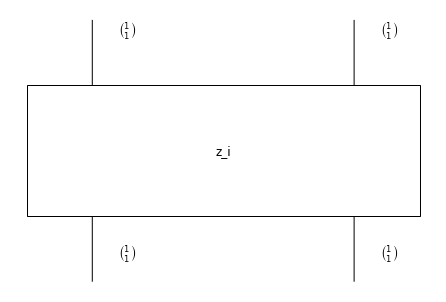

In [7]:
z_sampler = sampler.ImportanceSampler(gmm.SampleCluster(K), None, (NUM_SAMPLES,))
cluster_latent = tracing.TracedLensBox('z_i', lens.LensPRO(2), lens.LensPRO(2), z_sampler, z_sampler.update)
cluster_latent.draw()

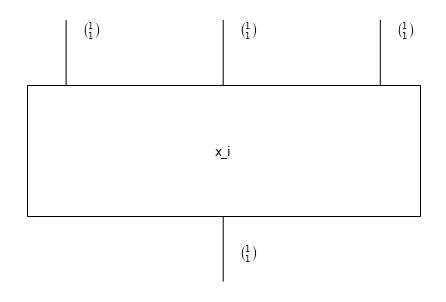

In [8]:
x_sampler = sampler.ImportanceSampler(gmm.SamplePoint(), None, (NUM_SAMPLES,))
observe_point = tracing.TracedLensBox('x_i', lens.LensPRO(3), lens.LensPRO(1), x_sampler, x_sampler.update)
observe_point.draw()

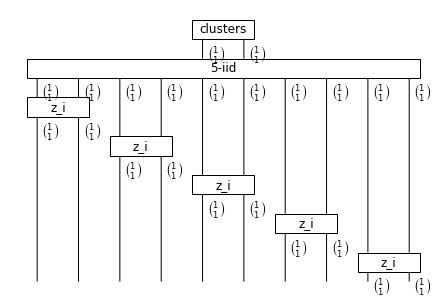

In [9]:
priors = clusters_prior >> collections.iid(clusters_prior.cod, N, cluster_latent)
priors.draw()

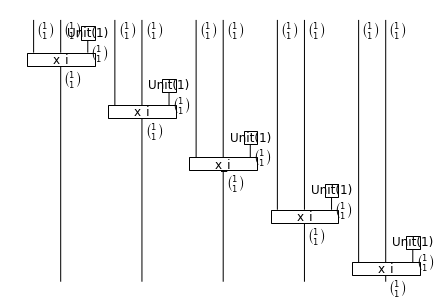

In [10]:
nones = [lens.Unit(None, lens.LensPRO(1)) for _ in range(N)]
unconditioned_xs = [lens.Id(lens.LensPRO(2)) @ none >> observe_point for none in nones]
likelihood = reduce(lambda f, g: f @ g, unconditioned_xs, lens.Id(lens.LensPRO(0)))
likelihood.draw()

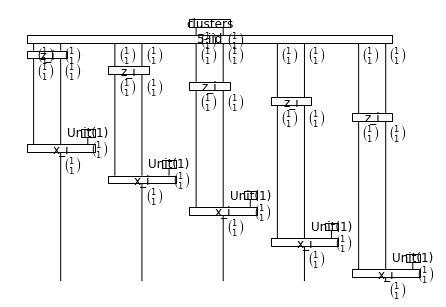

In [11]:
model = priors >> likelihood
model.draw()

In [12]:
model()

((tensor([[[-1.2024,  0.9463]]]),
  tensor([[[ 0.4088, 16.0786]]]),
  tensor([[[-0.3058,  0.4096]]]),
  tensor([[[-1.3931,  5.3976]]]),
  tensor([[[ 8.1981e-01, -1.1646e+03]]])),
 <class 'combinators.tracing.TraceDiagram'>.ARROW([<class 'combinators.tracing.TraceDiagram'>.BOX(((tensor([[ 0.3804, -0.4869],
         [ 0.2275,  0.9086],
         [ 0.1720,  0.2684]]), tensor([[1.0480e+00, 8.1179e+00],
         [4.0670e-01, 9.1054e+02],
         [1.2354e+00, 4.1551e-01]])), tensor([0.]), Trace{'mu': Normal([torch.FloatTensor of size 3x2]), 'tau': Gamma([torch.FloatTensor of size 3x2])}, 'clusters_sample')), <class 'combinators.tracing.TraceDiagram'>.BOX(((tensor([[ 0.3804, -0.4869],
         [ 0.2275,  0.9086],
         [ 0.1720,  0.2684]]), tensor([[1.0480e+00, 8.1179e+00],
         [4.0670e-01, 9.1054e+02],
         [1.2354e+00, 4.1551e-01]]), tensor([[ 0.3804, -0.4869],
         [ 0.2275,  0.9086],
         [ 0.1720,  0.2684]]), tensor([[1.0480e+00, 8.1179e+00],
         [4.0670e-01, 9.1